1. скачать набор данных маркетинговых кампаний
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [21]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# Чтение данных
df = pd.read_csv('HW_data.csv')
df.rename(columns={"conversion": "target", "offer": "treatment"}, inplace=True)
df.loc[df["treatment"] != "No Offer","treatment"] = 1
df.loc[df["treatment"] == "No Offer","treatment"] = 0

In [22]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [29]:
df["avg_rec_history"] = df["history"]/df["recency"]
#Те, кто покупает часто и много vs те, кто покупает редко и мало

3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [30]:
features = df.columns.drop("target")
target = "target"
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.20, random_state=23)

In [31]:
X_train.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,avg_rec_history
46639,5,48.91,0,1,Urban,1,Phone,0,9.782000
60571,7,109.18,1,0,Surburban,0,Phone,1,15.597143
20173,1,236.09,0,1,Urban,0,Phone,1,236.090000


In [57]:
cat_features = ['zip_code','channel']
treat_train = X_train['treatment']
treat_val = X_test['treatment']

models_results = {
    'approach': [],
    'uplift@10%' : [], 
    'uplift@20%' : [],
    'uplift@30%': []
}

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

uplift@10%: 0.0747
uplift@20%: 0.0642
uplift@30%: 0.0591


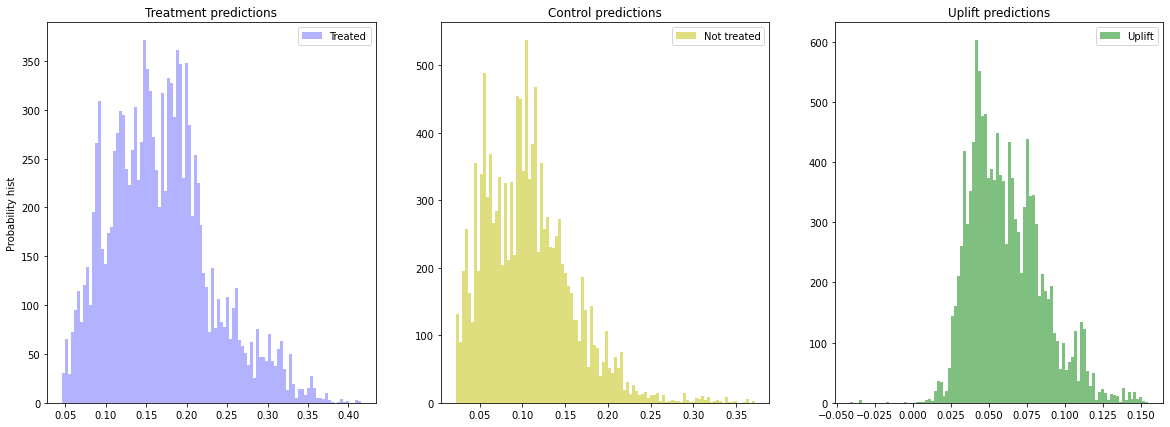

In [58]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

models_results['approach'].append('SoloModel')

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score:.4f}')

models_results['uplift@10%'].append(f'{sm_score:.4f}')

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score:.4f}')

models_results['uplift@20%'].append(f'{sm_score:.4f}')

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['uplift@30%'].append(f'{sm_score:.4f}')

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [59]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

models_results['approach'].append('ClassTransformation')

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(f'{ct_score:.4f}')

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
models_results['uplift@20%'].append(f'{ct_score:.4f}')

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)
models_results['uplift@30%'].append(f'{ct_score:.4f}')

<ipython-input-59-7f2a8e7adda0>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


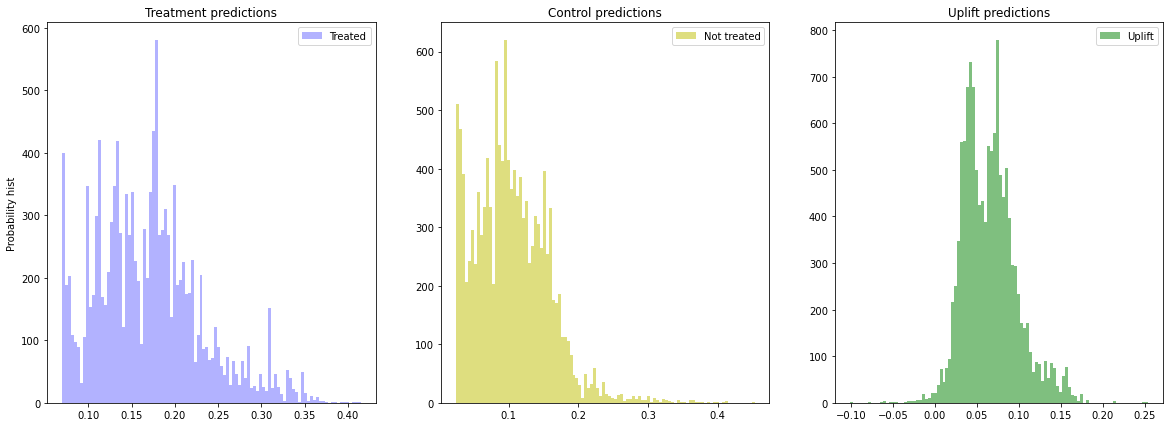

In [60]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

models_results['approach'].append('TwoModels')

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(f'{tm_score:.4f}')

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
models_results['uplift@20%'].append(f'{tm_score:.4f}')

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
models_results['uplift@30%'].append(f'{tm_score:.4f}')

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [61]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': ['0.0747', '0.2325', '0.0759'],
 'uplift@20%': ['0.0642', '0.1995', '0.0871'],
 'uplift@30%': ['0.0591', '0.1733', '0.0756']}

7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [ ]:
# !git clone https://github.com/uber/causalml.git
# %cd causalml
# !pip install -r requirements.txt
# !python setup.py build_ext --inplace
# !python setup.py install

In [69]:
%%time
from IPython.display import Image
import causalml
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: No module named 'causalml.inference'

Словами:
    Во-первых - есть пользователь uber, никакого ub8er нет.
    Во-вторых - видимо, структуру модуля опять поменяли, так как найти модуль causalml.inference тут так и не получилось -_-